In [1]:
import robust_regression.sweeps.alpha_sweeps as alsw
import matplotlib.pyplot as plt
from robust_regression.fixed_point_equations.fpe_L2_loss import (
    var_hat_func_L2_decorrelated_noise,
)
import robust_regression.regression_numerics.data_generation as dg
import robust_regression.aux_functions.prior_regularization_funcs as priors
import robust_regression.aux_functions.likelihood_channel_functions as like
import robust_regression.regression_numerics.amp_funcs as amp
import robust_regression.regression_numerics.erm_solvers as erm
from robust_regression.utils.errors import ConvergenceError
from robust_regression.fixed_point_equations.fpe_BO import var_func_BO, var_hat_func_BO_num_decorrelated_noise
from robust_regression.fixed_point_equations.fpe_L1_loss import (
    var_hat_func_L1_decorrelated_noise,
)
from robust_regression.fixed_point_equations.fpe_Huber_loss import (
    var_hat_func_Huber_decorrelated_noise,
)
from tqdm.auto import tqdm
from robust_regression.fixed_point_equations.fpe_L2_regularization import var_func_L2
from robust_regression.aux_functions.misc import excess_gen_error, gen_error_BO
import numpy as np

In [2]:
def sigma_order_param(m, q, sigma):
    return sigma


def q_order_param(m, q, sigma):
    return q


def m_order_param(m, q, sigma):
    return m

## Theory Simulations

In [3]:
delta_in, delta_out, percentage, beta = 1.0, 0.5, 0.6, 0.0
alpha_min, alpha_max, n_alpha_pts = 0.1, 1000, 100
n_alpha_pts_BO = 12

delta_eff = (1 - percentage) * delta_in + percentage * delta_out
plateau_alpha_inf = (1 - percentage) * percentage**2 * (1 - beta) ** 2 + percentage * (1 - percentage) ** 2 * (
    beta - 1
) ** 2
a_hub_fixed = 1.0

In [4]:
(
    alphas_L2,
    f_min_vals_L2,
    reg_param_opt_L2,
    (sigmas_L2, qs_L2, ms_L2),
) = alsw.sweep_alpha_optimal_lambda_fixed_point(
    var_func_L2,
    var_hat_func_L2_decorrelated_noise,
    alpha_min,
    alpha_max,
    n_alpha_pts,
    3.0,
    {"reg_param": 3.0},
    {
        "delta_in": delta_in,
        "delta_out": delta_out,
        "percentage": percentage,
        "beta": beta,
    },
    initial_cond_fpe=(0.6, 0.01, 0.9),
    f_min=excess_gen_error,
    f_min_args={"delta_in": delta_in, "delta_out": delta_out, "percentage": percentage, "beta": beta},
    funs=[sigma_order_param, q_order_param, m_order_param],
    funs_args=[{}, {}, {}],
    min_reg_param=1e-5
)

print("L2 done")

(
    alphas_L1,
    f_min_vals_L1,
    reg_param_opt_L1,
    (sigmas_L1, qs_L1, ms_L1),
) = alsw.sweep_alpha_optimal_lambda_fixed_point(
    var_func_L2,
    var_hat_func_L1_decorrelated_noise,
    alpha_min,
    alpha_max,
    n_alpha_pts,
    3.0,
    {"reg_param": 3.0},
    {
        "delta_in": delta_in,
        "delta_out": delta_out,
        "percentage": percentage,
        "beta": beta,
    },
    initial_cond_fpe=(0.6, 0.01, 0.9),
    f_min=excess_gen_error,
    f_min_args={"delta_in": delta_in, "delta_out": delta_out, "percentage": percentage, "beta": beta},
    funs=[sigma_order_param, q_order_param, m_order_param],
    funs_args=[{}, {}, {}],
    min_reg_param=1e-5,
)

print("L1 done")

(
    alphas_Hub,
    f_min_vals_Hub,
    (reg_param_opt_Hub, hub_params_opt_Hub),
    (sigmas_Hub, qs_Hub, ms_Hub),
) = alsw.sweep_alpha_optimal_lambda_hub_param_fixed_point(
    var_func_L2,
    var_hat_func_Huber_decorrelated_noise,
    alpha_min,
    alpha_max,
    n_alpha_pts,
    [3.0, 0.5],
    {"reg_param": 3.0},
    {
        "delta_in": delta_in,
        "delta_out": delta_out,
        "percentage": percentage,
        "beta": beta,
        "a": 1.0,
    },
    initial_cond_fpe=(0.6, 0.01, 0.9),
    f_min=excess_gen_error,
    f_min_args={"delta_in": delta_in, "delta_out": delta_out, "percentage": percentage, "beta": beta},
    funs=[sigma_order_param, q_order_param, m_order_param],
    funs_args=[{}, {}, {}],
    min_reg_param=1e-5,
)

print("Huber done")

(
    alphas_Hub_2,
    f_min_vals_Hub_2,
    reg_param_opt_Hub_2,
    (sigmas_Hub_2, qs_Hub_2, ms_Hub_2),
) = alsw.sweep_alpha_optimal_lambda_fixed_point(
    var_func_L2,
    var_hat_func_Huber_decorrelated_noise,
    alpha_min,
    alpha_max,
    n_alpha_pts,
    3.0,
    {"reg_param": 3.0},
    {
        "delta_in": delta_in,
        "delta_out": delta_out,
        "percentage": percentage,
        "beta": beta,
        "a": a_hub_fixed,
    },
    initial_cond_fpe=(0.6, 0.01, 0.9),
    f_min=excess_gen_error,
    f_min_args={"delta_in": delta_in, "delta_out": delta_out, "percentage": percentage, "beta": beta},
    funs=[sigma_order_param, q_order_param, m_order_param],
    funs_args=[{}, {}, {}],
    min_reg_param=1e-5,
)

print("Huber a fixed done")

alphas_BO, (gen_error_BO_old, qs_BO) = alsw.sweep_alpha_fixed_point(
    var_func_BO,
    var_hat_func_BO_num_decorrelated_noise,
    alpha_min,
    alpha_max,
    n_alpha_pts_BO,
    {"reg_param": 1e-5},
    {
        "delta_in": delta_in,
        "delta_out": delta_out,
        "percentage": percentage,
        "beta": beta,
    },
    initial_cond_fpe=(0.6, 0.01, 0.9),
    funs=[gen_error_BO, q_order_param],
    funs_args=[{"delta_in": delta_in, "delta_out": delta_out, "percentage": percentage, "beta": beta}, {}],
    decreasing=False,
)

print("BO done")

L2 done
L1 done
Huber done
Huber a fixed done
BO done


## Numerical Experiments

In [5]:
d = 500
repetitions = 10

end = 4
skip = 7

print("alphas expample\n", alphas_L2[::skip][1:-end])

alphas expample
 [ 0.19179103  0.36783798  0.70548023  1.35304777  2.59502421  4.97702356
  9.54548457 18.3073828  35.11191734 67.34150658]


In [6]:
alpha_list_sim_L2 = alphas_L2[::skip][1:-end]
lambd_list_L2 = reg_param_opt_L2[::skip][1:-end]

L2_gen_error_sim_mean = np.zeros(len(alpha_list_sim_L2))
L2_gen_error_sim_std = np.zeros(len(alpha_list_sim_L2))

for i, (alpha, lambd) in enumerate(zip(tqdm(alpha_list_sim_L2), lambd_list_L2)):
    all_gen_errors = np.empty((repetitions,))
    for idx in range(repetitions):
        xs, ys, xs_test, ys_test, ground_truth_theta = dg.data_generation(
            dg.measure_gen_decorrelated,
            n_features=d,
            n_samples=max(int(np.around(d * alpha)), 1),
            n_generalization=d,
            measure_fun_args=(delta_in, delta_out, percentage, beta),
        )

        estimated_theta = erm.find_coefficients_L2(ys, xs, lambd)

        all_gen_errors[idx] = np.mean((ys_test - xs_test @ estimated_theta / np.sqrt(d)) ** 2) - np.mean(
            (ys_test - (1 - percentage + percentage * beta) * xs_test @ ground_truth_theta / np.sqrt(d)) ** 2
        )

        del xs, ys, xs_test, ys_test, ground_truth_theta, estimated_theta

    L2_gen_error_sim_mean[i], L2_gen_error_sim_std[i] = np.mean(all_gen_errors), np.std(all_gen_errors) / np.sqrt(
        repetitions
    )

print("L2 sim done")

  0%|          | 0/10 [00:00<?, ?it/s]

L2 sim done


In [7]:
alpha_list_sim_Hub = alphas_Hub[::skip][1:-end]
a_list_Hub = hub_params_opt_Hub[::skip][1:-end]
lambd_list_Hub = reg_param_opt_Hub[::skip][1:-end]

Huber_gen_error_sim_mean = np.zeros(len(alpha_list_sim_Hub))
Huber_gen_error_sim_std = np.zeros(len(alpha_list_sim_Hub))


for i, (alpha, lambd, a) in enumerate(zip(tqdm(alpha_list_sim_Hub), lambd_list_Hub, a_list_Hub)):
    all_gen_errors = np.empty((repetitions,))
    for idx in range(repetitions):
        xs, ys, xs_test, ys_test, ground_truth_theta = dg.data_generation(
            dg.measure_gen_decorrelated,
            n_features=d,
            n_samples=max(int(np.around(d * alpha)), 1),
            n_generalization=d,
            measure_fun_args=(delta_in, delta_out, percentage, beta),
        )

        estimated_theta = erm.find_coefficients_Huber(ys, xs, lambd, a, 1.0)

        all_gen_errors[idx] = np.mean((ys_test - xs_test @ estimated_theta / np.sqrt(d)) ** 2) - np.mean(
            (ys_test - (1 - percentage + percentage * beta) * xs_test @ ground_truth_theta / np.sqrt(d)) ** 2
        )

        del xs, ys, xs_test, ys_test, ground_truth_theta, estimated_theta

    Huber_gen_error_sim_mean[i], Huber_gen_error_sim_std[i] = np.mean(all_gen_errors), np.std(all_gen_errors) / np.sqrt(
        repetitions
    )

print("Huber sim done.")

  0%|          | 0/10 [00:00<?, ?it/s]

0.19179102616724888 5.874999867607793 9.941298240294065
0.36783797718286343 5.8750001519214905 12.255925969440856
0.7054802310718644 5.8750013124009834 14.713314647085843
1.3530477745798075 5.874999599957423 16.110775685269022
2.5950242113997373 5.874999401150143 17.73506408249901
4.977023564332112 5.8750006118549365 18.603372005279944
9.545484566618342 5.875001227307788 23.492144753677227
18.307382802953697 5.875000104712105 26.97186972039156
35.111917342151344 5.8750007806108036 33.457625041602896
67.34150657750828 5.875002330590728 34.146331741566684
Huber sim done.


In [22]:
alpha_list_sim_L1 = alphas_L1[::skip][1:-end]
lambd_list_L1 = reg_param_opt_L1[::skip][1:-end]

a_val_L1 = 1e-3
lambd_list_L1 *= a_val_L1

L1_gen_error_sim_mean = np.zeros(len(alpha_list_sim_L1))
L1_gen_error_sim_std = np.zeros(len(alpha_list_sim_L1))

for i, (alpha, lambd) in enumerate(zip(tqdm(alpha_list_sim_L1), lambd_list_L1)):
    all_gen_errors = np.empty((repetitions,))
    for idx in range(repetitions):
        xs, ys, xs_test, ys_test, ground_truth_theta = dg.data_generation(
            dg.measure_gen_decorrelated,
            n_features=d,
            n_samples=max(int(np.around(d * alpha)), 1),
            n_generalization=d,
            measure_fun_args=(delta_in, delta_out, percentage, beta),
        )

        estimated_theta = erm.find_coefficients_Huber(ys, xs, lambd, a_val_L1)

        all_gen_errors[idx] = np.mean((ys_test - xs_test @ estimated_theta / np.sqrt(d)) ** 2) - np.mean(
            (ys_test - (1 - percentage + percentage * beta) * xs_test @ ground_truth_theta / np.sqrt(d)) ** 2
        )

        del xs, ys, xs_test, ys_test, ground_truth_theta, estimated_theta

    L1_gen_error_sim_mean[i], L1_gen_error_sim_std[i] = np.mean(all_gen_errors), np.std(all_gen_errors) / np.sqrt(
        repetitions
    )

print("L1 sim done.")

  0%|          | 0/8 [00:00<?, ?it/s]

L1 sim done.


In [23]:
alpha_list_sim_Huber_a1 = alphas_Hub_2[::skip][1:-end]
# a = a_hub_fixed
lambd_list_Hub_fix = reg_param_opt_Hub_2[::skip][1:-end]

Huber_gen_error_sim_mean_a1 = np.zeros(len(alpha_list_sim_Huber_a1))
Huber_gen_error_sim_std_a1 = np.zeros(len(alpha_list_sim_Huber_a1))

for i, (alpha, lambd) in enumerate(zip(tqdm(alpha_list_sim_Huber_a1), lambd_list_Hub_fix)):
    all_gen_errors = np.empty((repetitions,))
    for idx in range(repetitions):
        xs, ys, xs_test, ys_test, ground_truth_theta = dg.data_generation(
            dg.measure_gen_decorrelated,
            n_features=d,
            n_samples=max(int(np.around(d * alpha)), 1),
            n_generalization=d,
            measure_fun_args=(delta_in, delta_out, percentage, beta),
        )

        estimated_theta = erm.find_coefficients_Huber(ys, xs, lambd, a_hub_fixed)

        all_gen_errors[idx] = np.mean((ys_test - xs_test @ estimated_theta / np.sqrt(d)) ** 2) - np.mean(
            (ys_test - (1 - percentage + percentage * beta) * xs_test @ ground_truth_theta / np.sqrt(d)) ** 2
        )

        del xs, ys, xs_test, ys_test, ground_truth_theta, estimated_theta

    Huber_gen_error_sim_mean_a1[i], Huber_gen_error_sim_std_a1[i] = np.mean(all_gen_errors), np.std(
        all_gen_errors
    ) / np.sqrt(repetitions)

print("Huber fixed a sim done.")

  0%|          | 0/8 [00:00<?, ?it/s]

Huber fixed a sim done.


In [81]:
alphas = np.array(
    [
        1.34977233e-01,
        1.82188534e-01,
        2.45913043e-01,
        3.31926620e-01,
        4.48025368e-01,
        6.04732245e-01,
        8.16250851e-01,
        1.10175281e00,
        1.48711546e00,
        2.00726730e00,
        2.70935387e00,
        3.65701088e00,
        4.93613210e00,
        6.66265452e00,
        8.99306672e00,
        1.21385926e01,
        1.63843365e01,
        2.21151240e01,
        2.98503825e01,
        4.02912203e01,
        5.43839743e01,
        7.34059837e01,
        9.90813657e01
    ]
)

means_gen_error = []
stds_gen_error = []

alphas_2 = []

for _, alpha in enumerate(tqdm(alphas)):
    all_gen_errors = []
    all_estim_errors = []

    for _ in range(repetitions):
        try:
            xs, ys, xs_test, ys_test, ground_truth_theta = dg.data_generation(
                dg.measure_gen_decorrelated,
                n_features=d,
                n_samples=max(int(np.around(d * alpha)), 1),
                n_generalization=2 * d,
                measure_fun_args=(delta_in, delta_out, percentage, beta),
            )

            estimated_theta, _ = amp.GAMP_unsimplified_iters(
                priors.f_w_Bayes_gaussian_prior,
                priors.Df_w_Bayes_gaussian_prior,
                like.f_out_Bayes_decorrelated_noise,
                like.Df_out_Bayes_decorrelated_noise,
                ys,
                xs,
                (0.0, 1.0),
                (delta_in, delta_out, percentage, beta),
                np.random.normal(size=d),
                1.0,
                max_iter=10_000,
                blend=0.85,
            )

            all_gen_errors.append(
                np.mean((ys_test - (1 - percentage + percentage * beta) * xs_test @ estimated_theta / np.sqrt(d)) ** 2)
                - np.mean(
                    (ys_test - (1 - percentage + percentage * beta) * xs_test @ ground_truth_theta / np.sqrt(d)) ** 2
                )
            )

            all_estim_errors.append(np.mean(np.square(estimated_theta - ground_truth_theta)))

            del xs, ys, xs_test, ys_test, ground_truth_theta, estimated_theta

        except ConvergenceError:
            continue

    means_gen_error.append(np.mean(all_gen_errors))
    stds_gen_error.append(np.std(all_gen_errors) / np.sqrt(repetitions))

    alphas_2.append(alpha)
print("GAMP sim done.")

  0%|          | 0/23 [00:00<?, ?it/s]

GAMP sim done.


## Plotting

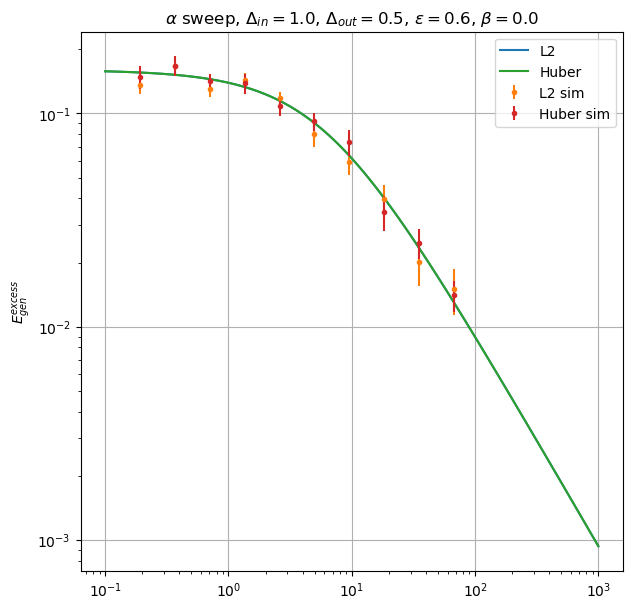

In [8]:
plt.figure(figsize=(7, 7))

plt.title(
    "$\\alpha$ sweep, $\\Delta_{{in}} = {}$, $\\Delta_{{out}} = {}$, $\\epsilon = {}$, $\\beta = {}$".format(
        delta_in, delta_out, percentage, beta
    )
)

plt.plot(alphas_L2, f_min_vals_L2, label="L2")
plt.errorbar(alpha_list_sim_L2, L2_gen_error_sim_mean, L2_gen_error_sim_std, linestyle=" ", marker=".", label="L2 sim")
# plt.plot(alphas_L1, f_min_vals_L1, label="L1")
# plt.errorbar(alpha_list_sim_L1, L1_gen_error_sim_mean, L1_gen_error_sim_std, linestyle=" ", marker=".", label="L1 sim")
plt.plot(alphas_Hub, f_min_vals_Hub, label="Huber")
plt.errorbar(
    alpha_list_sim_Hub, Huber_gen_error_sim_mean, Huber_gen_error_sim_std, linestyle=" ", marker=".", label="Huber sim"
)
# plt.plot(alphas_Hub_2, f_min_vals_Hub_2, label="Huber a={:.1f}".format(a_hub_fixed))
# plt.errorbar(
#     alpha_list_sim_Huber_a1,
#     Huber_gen_error_sim_mean_a1,
#     Huber_gen_error_sim_std_a1,
#     linestyle=" ",
#     marker=".",
#     label="Huber a={:.1f} sim".format(a_hub_fixed),
# )
# plt.plot(alphas_BO, gen_error_BO_old, label="BO")
# plt.errorbar(alphas_2, means_gen_error, yerr=stds_gen_error, label="GAMP", marker=".", linestyle=None)

plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"$E_{gen}^{excess}$")
plt.legend()
plt.grid()

plt.show()